In [2]:
import healpy as hp
import numpy as np
import pymaster as nmt
import imp
import matplotlib.pyplot as plt

from Pseudo_Cl import Pseudo_Cl

import utils

%matplotlib inline

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


# Data

In [3]:
cmb = hp.read_map('/home/jianyao/Ali_maps/data/TQU_CMB_r7.fits', field = None, verbose = False)

ali_ma = hp.read_map('/home/jianyao/Ali_maps/data/ali_mask_r7.fits', verbose = False)

fore30 = hp.read_map('/home/jianyao/Ali_maps/data/TQU_30GHz_r7.fits', field = None, verbose = False);
fore95 = hp.read_map('/home/jianyao/Ali_maps/data/TQU_95GHz_r7.fits', field = None, verbose = False);
fore150 = hp.read_map('/home/jianyao/Ali_maps/data/TQU_150GHz_r7.fits', field = None, verbose = False)
fore353 = hp.read_map('/home/jianyao/Ali_maps/data/TQU_353GHz_r7.fits', field = None, verbose = False)

In [4]:
nside = 128;

In [5]:
mask_index = np.where(ali_ma==1)[0]

In [6]:
Noise_var = np.zeros((4, 3, 12*nside**2))
Noise_var[0] = hp.read_map('/home/jianyao/Ali_maps/data/TQU_var_30GHz_r7.fits', field = None, verbose = False);
Noise_var[1] = hp.read_map('/home/jianyao/Ali_maps/data/TQU_var_95GHz_r7.fits', field = None, verbose = False);
Noise_var[2] = hp.read_map('/home/jianyao/Ali_maps/data/TQU_var_150GHz_r7.fits', field = None, verbose = False);
Noise_var[3] = hp.read_map('/home/jianyao/Ali_maps/data/TQU_var_353GHz_r7.fits', field = None, verbose = False);

# PS

In [133]:
ps_e = Pseudo_Cl(mask_in = ali_ma, nside = 128, bin_w = 20, lmax = 200)

In [134]:
SamNum = 1
for n in range(SamNum):

    Noise = np.zeros((4, 3, 12*nside**2)); 
    for i in range(4):
        for k in mask_index:
            Noise[i,1,k] = np.random.normal(0, np.sqrt(Noise_var[i,1,k]));
            Noise[i,2,k] = np.random.normal(0, np.sqrt(Noise_var[i,2,k]));

    total = np.zeros((4, 3, 12*nside**2))
    total[0] = fore30 + Noise[0]
    total[1] = fore95 + Noise[1]
    total[2] = fore150 + Noise[2]
    total[3] = fore353 + Noise[3]
    
    nl_i = ps_e.Cross_EB(Noise)
    total_ps_i = ps_e.Cross_EB(total)
    
    np.save('/home/jianyao/Ali_maps/data/nl/nl_%s.npy'%n, nl_i)
    np.save('/home/jianyao/Ali_maps/data/tcl/tcl_%s.npy'%n, total_ps_i)

In [149]:
total_ps_i[0][2]

array([[0.00869904, 0.00071694, 0.00077095, 0.00610391],
       [0.00071694, 0.00062355, 0.00063275, 0.00712283],
       [0.00077095, 0.00063275, 0.00131389, 0.01785745],
       [0.00610391, 0.00712283, 0.01785745, 0.39584765]])

In [138]:
nl_i[0][0]

array([[ 1.52877901e-04,  6.03479248e-06, -1.65701058e-04,
         5.29929324e-04],
       [ 6.03479248e-06, -1.24339915e-03, -1.44140116e-04,
        -5.61962013e-04],
       [-1.65701058e-04, -1.44140116e-04,  3.22494328e-05,
         2.79926098e-04],
       [ 5.29929324e-04, -5.61962013e-04,  2.79926098e-04,
        -3.84809691e-05]])

In [165]:
b = nmt.NmtBin(128, nlb=20, lmax = 200); ell_n = b.get_effective_ells(); eln2 = utils.l2(ell_n)

In [166]:
mask = nmt.mask_apodization(ali_ma, 5, apotype='Smooth') 

b_real = nmt.NmtField(mask,cmb[1:], purify_e=False, purify_b=True)
cl_real = nmt.compute_full_master(b_real, b_real, b) # real

# ABS

In [272]:
SamNum = 100; path = '/home/jianyao/Ali_maps/data/'
Q = len(ell_n); Nf = 4
nl_all_bin = np.ones((SamNum, Q, Nf, Nf))

for i in range(SamNum):
    noise_ps_i = np.load('%s/nl/nl_%s.npy'%(path, i))
    
    for l in range(Q):
        noise_ps_i[0][l] *= eln2[l]
        noise_ps_i[1][l] *= eln2[l]
   
    nl_all_bin[i] = noise_ps_i[1] #bin_l(noise_ps_i[0], lmax, Q); 
#     nl_all_bin[i,1] = noise_ps_i[1] #bin_l(noise_ps_i[1], lmax, Q)
    
nl_bin_mean_all = np.mean(nl_all_bin, axis = 0); nl_bin_std_all = np.std(nl_all_bin, axis = 0)

In [301]:
import ABS_ILC_class
imp.reload(ABS_ILC_class)

<module 'ABS_ILC_class' from '/home/jianyao/Ali_maps/codes/ABS_ILC_class.py'>

In [302]:
abs_e = ABS_ILC_class.ABS(nside, lmax = 200, bin_w=20, cut = 1)

In [303]:
Cl = np.zeros((SamNum, Q)); sel = [0,1,2,3]; ClEE = np.zeros((SamNum, Q))

for n in range(1):#(SamNum):
    
    total_cl = np.load('%s/tcl/tcl_%s.npy'%(path, n))
    
    for l in range(Q):
        total_cl[0][l] *= eln2[l]
        total_cl[1][l] *= eln2[l]
        
        
    Cl[n] = abs_e.run(total_cl[1], nl_bin_mean_all, nl_bin_std_all, sel)
#     ClEE[n] = abs_e.run(total_cl[0], nl_bin_mean_all, nl_bin_std_all, sel)

In [300]:
1/np.sqrt(0.18673162)

2.3141476640801795

In [276]:
cl_abs_mean = np.mean(Cl, axis = 0)
cl_abs_std = np.std(Cl, axis = 0)

cl_abs_ee_mean = np.mean(ClEE, axis = 0);
cl_abs_ee_std = np.mean(ClEE, axis = 0);

Text(0, 0.5, '$D_{\\ell}(\\mu K^2)$')

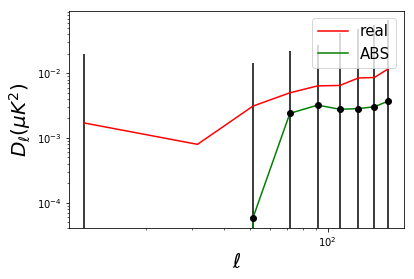

In [277]:
plt.loglog(ell_n, eln2*cl_real[3],'r-', label = 'real')
plt.loglog(ell_n, cl_abs_mean, 'g-', label = 'ABS')

# plt.loglog(ell_n, eln2*cl_real[0],'b-', label = 'real EE')
# plt.loglog(ell_n, cl_abs_ee_mean, 'b--', label = 'ABS EE')

# plt.errorbar(ell_n, eln2*cl_abs_ee_mean, yerr=eln2*cl_abs_ee_std, fmt = 'ko')

plt.errorbar(ell_n, cl_abs_mean, yerr=cl_abs_std, fmt = 'ko')
plt.legend(fontsize = 15)

# plt.ylim(1e-4, 10)
plt.xlabel('$\ell$', fontsize = 20);
plt.ylabel('$D_{\ell}(\mu K^2)$', fontsize = 20)

In [279]:
cl_abs_std

array([0.0825395 , 0.27719142, 0.01446363, 0.01980771, 0.02373746,
       0.03930774, 0.04523517, 0.05313045, 0.0618264 ])

In [278]:
cl_abs_mean

array([-6.25243490e-02, -1.14203761e+00,  5.75096661e-05,  2.39409439e-03,
        3.21765276e-03,  2.77016007e-03,  2.83942637e-03,  3.03308817e-03,
        3.71766459e-03])

# compare

In [173]:
tcl = np.load('/home/jianyao/Ali_maps/data/tcl/tcl_0.npy')

In [179]:
ell_n

array([ 11.5,  31.5,  51.5,  71.5,  91.5, 111.5, 131.5, 151.5, 171.5])

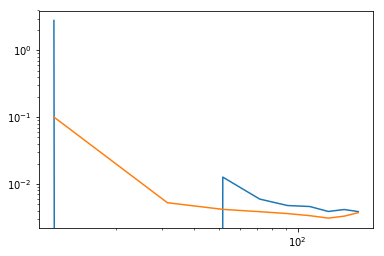

In [184]:
plt.loglog(ell_n,(tcl[0,:,0,0]))
plt.loglog(ell_n, (tcl[1,:,0,0]))

In [178]:
tcl[0,:,0,0]

array([ 2.80852888, -0.0657604 ,  0.01267529,  0.00593949,  0.00475747,
        0.00459705,  0.00387673,  0.00414663,  0.00385404])